Performs Lasso Regression on Dummified data set to do feature selection on coefficients 

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso

In [126]:
data_train = pd.read_csv('initial_dummied_data_TRAIN.csv')
data_test = pd.read_csv('initial_dummied_data_TEST.csv')


In [127]:
# list(data_train.columns)

In [128]:
data_train.head()

,SalePrice,GrLivArea,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,MSSubClass_>1-story,MSSubClass_multi_fam,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_Timber,UnpavedDrive,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S
0,143000,1632,1632,0,8,4,2,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,153500,1226,1226,0,7,2,1,1,0,0,...,0,0,0,0,1,1,0,1,0,0
2,199900,1241,1241,0,4,1,1,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3,113000,793,793,0,4,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,131900,796,796,0,4,2,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0


# Lasso on Dummy Data

In [129]:

data_testx=data_test.iloc[:,1:]
data_testy=data_test.iloc[:,0]
data_trainx=data_train.iloc[:,1:]
data_trainy=data_train.iloc[:,0]


In [130]:
#standardize non binary cats
nonbinarycols=['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'BedroomAbvGr',
       'FullBath', 'HalfBath',  'LotArea',
       'LndAc_S',   'MasVnrArea',
        'YearBuilt',
       'OverallQual', 'TotalBsmtSF', 'BsmtUnfSF',
        'BsmtHalfBath', 'BsmtFullBath', 
        'GarageArea', 'GarageCars',  'Fireplaces'
        ]

In [131]:
#standardize non binary cols for lasso
for i in (nonbinarycols):
    data_trainx[i]=(data_trainx[i] - data_trainx[i].mean()) / data_trainx[i].std()    
    
for i in (nonbinarycols):
    data_testx[i]=(data_testx[i] - data_testx[i].mean()) / data_testx[i].std() 

In [132]:
data_testx.head()

,GrLivArea,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,MSSubClass_>1-story,MSSubClass_multi_fam,BldgType_Twnhs,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_Timber,UnpavedDrive,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S
0,-0.129009,0.774679,-0.809460,0.372342,0.170306,0.793284,-0.747727,0,0,0,...,0,0,0,0,0,1,0,0.549877,0,0
1,-1.017627,-1.788910,0.355272,-0.912012,-1.049028,-1.048345,1.236895,1,0,1,...,0,0,0,0,1,0,0,-0.942146,0,0
2,0.983234,-0.162893,1.309705,1.014519,0.170306,0.793284,-0.747727,1,0,0,...,0,0,0,0,0,1,0,-0.942146,0,0
3,1.891468,3.533819,-0.809460,0.372342,-2.268363,-1.048345,1.236895,0,0,0,...,0,0,0,0,1,1,0,2.041901,0,1
4,0.892999,-0.929023,1.864339,0.372342,0.170306,0.793284,1.236895,1,0,0,...,0,0,0,0,1,1,0,0.549877,0,0


Broad view of the test and train R2 as penalization grows

In [133]:
lasso  = Lasso(normalize=True)
alphas = np.linspace(0,2500,1000)
lasso.set_params()
coefs_lasso  = []
trainr2=[]
testr2=[]

for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(data_trainx, data_trainy) 
        trainr2.append(lasso.score(data_trainx, data_trainy))
        testr2.append(lasso.score(data_testx, data_testy))
        coefs_lasso.append(lasso.coef_)
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = data_trainx.columns)  
coefs_lasso.head()

  

<ipython-input-133-ae4fbfead1c3>:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(data_trainx, data_trainy)
/Users/AJ/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/AJ/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274898483436.9785, tolerance: 889070378.6549126
  model = cd_fast.enet_coordinate_descent(


,GrLivArea,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,MSSubClass_>1-story,MSSubClass_multi_fam,BldgType_Twnhs,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_Timber,UnpavedDrive,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S
0.000000,1120.959260,12837.031069,16267.638303,-659.946150,-2345.138291,605.603511,1220.498255,-1149.706068,-13876.423697,-24073.309540,...,-12534.340436,-3724.172389,-8408.796729,-1849.142986,224.648749,-1503.075924,1245.673733,3242.288674,-3392.887830,16594.343250
2.502503,9661.915513,5146.973662,7038.970129,-182.435348,-2004.331406,308.274318,1175.837490,-10.177275,-10248.411050,-18810.522643,...,-7163.046663,-0.000000,-3731.289567,-1665.942150,140.830549,-1395.988516,756.147738,2066.082073,-3237.712915,15603.937244
5.005005,15556.537743,0.000000,817.219819,-0.000000,-1611.450069,0.000000,1110.120243,-0.000000,-8546.342226,-16043.744986,...,-5479.369786,0.000000,-1985.530000,-1516.169817,30.461967,-1155.885672,411.592474,1835.665791,-2981.407610,12586.282036
7.507508,15507.812961,0.000000,0.000000,-0.000000,-1212.607531,0.000000,1110.658441,-0.000000,-7368.223792,-14079.844215,...,-4382.577817,0.000000,-937.732800,-1441.152496,0.000000,-950.326844,95.647762,1654.368942,-2692.537911,9255.973741
10.010010,14881.190582,0.000000,0.000000,-0.000000,-919.184386,0.000000,975.707890,-0.000000,-6450.834893,-12286.713708,...,-3277.715104,0.000000,-0.000000,-1428.848322,0.000000,-758.450460,0.000000,1518.821896,-2807.582313,5865.323283


Text(0, 0.5, '$R^2$')

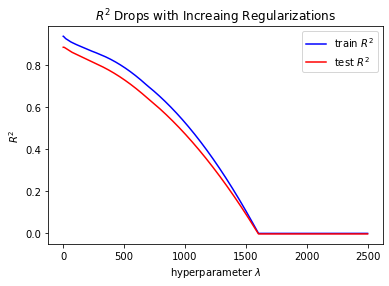

In [10]:
plt.plot(alphas, trainr2, c='b', label=r'train $R^2$')
plt.plot(alphas, testr2, c='r', label=r'test $R^2$')
plt.legend(loc=1)
plt.title(r'$R^2$ Drops with Increaing Regularizations')
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

Zoomed in on where test and train r2 are maxed 

In [11]:
lasso  = Lasso(normalize=True)
alphas = np.linspace(0,5,1000)
lasso.set_params()
coefs_lasso  = []
trainr2=[]
testr2=[]

for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(data_trainx, data_trainy) 
        trainr2.append(lasso.score(data_trainx, data_trainy))
        testr2.append(lasso.score(data_testx, data_testy))
        coefs_lasso.append(lasso.coef_)
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = data_trainx.columns)  
coefs_lasso.head()

  

<ipython-input-11-8f9b48ac74a6>:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(data_trainx, data_trainy)
/Users/AJ/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/AJ/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274898483436.9785, tolerance: 889070378.6549126
  model = cd_fast.enet_coordinate_descent(
/Users/AJ/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12908488200.645386, tolerance: 8890

,GrLivArea,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,MSSubClass_>1-story,MSSubClass_multi_fam,BldgType_Twnhs,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_Timber,UnpavedDrive,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S
0.000000,1120.959260,12837.031069,16267.638303,-659.946150,-2345.138291,605.603511,1220.498255,-1149.706068,-13876.423697,-24073.309540,...,-12534.340436,-3724.172389,-8408.796729,-1849.142986,224.648749,-1503.075924,1245.673733,3242.288674,-3392.887830,16594.343250
0.005005,1137.132619,12822.263074,16250.296678,-659.078927,-2344.146122,605.019910,1220.499175,-1148.152691,-13811.992667,-24059.806452,...,-12520.660256,-3713.357151,-8397.583725,-1849.567103,224.502892,-1503.089074,1244.743875,3239.235645,-3391.909921,16593.881688
0.010010,1153.305975,12807.495081,16232.955055,-658.211704,-2343.153954,604.436309,1220.500096,-1146.599314,-13747.561637,-24046.303363,...,-12506.980075,-3702.541912,-8386.370720,-1849.991220,224.357036,-1503.102225,1243.814017,3236.182616,-3390.932012,16593.420125
0.015015,1169.479308,12792.727107,16215.613452,-657.344480,-2342.161785,603.852708,1220.501017,-1145.045936,-13683.130607,-24032.800276,...,-12493.299895,-3691.726674,-8375.157717,-1850.415337,224.211179,-1503.115375,1242.884158,3233.129587,-3389.954103,16592.958562
0.020020,1185.652644,12777.959129,16198.271846,-656.477256,-2341.169617,603.269107,1220.501938,-1143.492558,-13618.699576,-24019.297188,...,-12479.619715,-3680.911436,-8363.944713,-1850.839454,224.065323,-1503.128525,1241.954300,3230.076559,-3388.976193,16592.496999


In [12]:

#alpha which maximized the testr2
maxind=testr2.index(max(testr2))
bestalpha=alphas[maxind]
bestalpha

1.8018018018018018

Text(0, 0.5, '$R^2$')

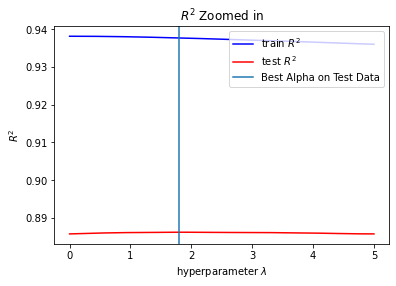

In [13]:
plt.plot(alphas, trainr2, c='b', label=r'train $R^2$')
plt.plot(alphas, testr2, c='r', label=r'test $R^2$')
plt.axvline(x=bestalpha,label=r'Best Alpha on Test Data')
plt.legend(loc=1)
plt.title(r'$R^2$ Zoomed in')
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')



In [14]:
# for name in coefs_lasso.columns:
#     plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
# plt.xlabel(r'hyperparameter $\lambda$')
# plt.ylabel(r'slope values')
## plt.legend(loc=1) 

In [15]:
sum(coefs_lasso.iloc[maxind]!=0)

93

In [16]:
#visualize number of coefs used per alpha

num_nonzero_coef=[]
for i in range(len(alphas)):
    num_nonzero_coef.append(sum(coefs_lasso.iloc[i]!=0))

No handles with labels found to put in legend.


Text(0, 0.5, '# non zero coefs')

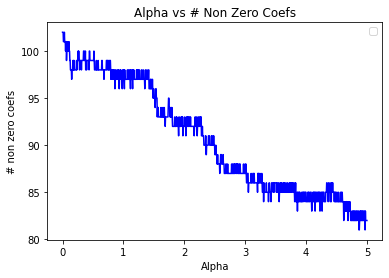

In [17]:
plt.plot(alphas, num_nonzero_coef, c='b')
plt.legend(loc=1)
plt.title(r'Alpha vs # Non Zero Coefs')
plt.xlabel(r'Alpha')
plt.ylabel(r'# non zero coefs')

Text(0.5, 0, '# non zero coefs')

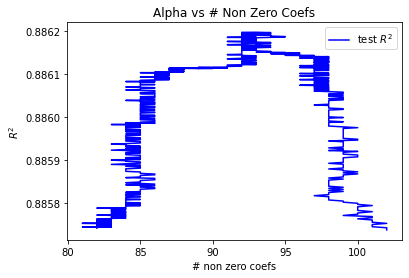

In [18]:
plt.plot(num_nonzero_coef,testr2, c='b', label=r'test $R^2$')
plt.legend(loc=1)
plt.title(r'Alpha vs # Non Zero Coefs')
plt.ylabel(r'$R^2$')
plt.xlabel(r'# non zero coefs')

In [19]:
#Examining the best model

lasso.set_params(alpha=bestalpha)
lasso.fit(data_trainx, data_trainy)

print('The train R2 is ',lasso.score(data_trainx, data_trainy))
print('The test R2 is ',lasso.score(data_testx, data_testy))
#pd.DataFrame(lasso.coef_,  columns = data_trainx.columns)
columns = data_trainx.columns
coeflist=list(zip(columns,lasso.coef_))
coefdf=pd.DataFrame(coeflist, columns=['Attr','Coef'])
coefdf=coefdf[coefdf.Coef!=0]
coefdf.sort_values(by=['Coef'],key=abs)

The train R2 is  0.9377042924679799
The test R2 is  0.8861974447925868


,Attr,Coef
74,GarageFinish_None,2.543440e-13
93,Neighborhood_Somerst,-1.565878e+00
30,Exterior1st_HdbdOther,-9.424932e+00
51,RemodelYrsAftBuilt,1.246061e+02
76,GarageCars,1.744734e+02
...,...,...
53,Functional_Maj,-1.930938e+04
9,BldgType_Twnhs,-1.981750e+04
83,Neighborhood_Gilbert,-2.453486e+04
13,LndAc_S,2.486356e+04


# Lasso on Dummy Data w Log SalePrice

In [140]:
# create copy of train/test 
log_data_train = data_train
log_data_test = data_test

In [141]:
# log SalePrice and drop original column in test and train

log_data_train['log_SalePrice'] = np.log(log_data_train['SalePrice'])
log_data_train = log_data_train.drop(['SalePrice'], axis=1)
log_first_column = log_data_train.pop('log_SalePrice')
log_data_train.insert(0, 'log_SalePrice', log_first_column)

log_data_test['log_SalePrice'] = np.log(log_data_test['SalePrice'])
log_data_test = log_data_test.drop(['SalePrice'], axis=1)
log_first_columnt = log_data_test.pop('log_SalePrice')
log_data_test.insert(0, 'log_SalePrice', log_first_columnt)

In [142]:
log_data_testx=data_testx
log_data_testy=log_data_test.iloc[:,0]
log_data_trainx=data_trainx
log_data_trainy=log_data_train.iloc[:,0]

In [143]:
log_data_testx.head()

,GrLivArea,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,MSSubClass_>1-story,MSSubClass_multi_fam,BldgType_Twnhs,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_Timber,UnpavedDrive,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S
0,-0.129009,0.774679,-0.809460,0.372342,0.170306,0.793284,-0.747727,0,0,0,...,0,0,0,0,0,1,0,0.549877,0,0
1,-1.017627,-1.788910,0.355272,-0.912012,-1.049028,-1.048345,1.236895,1,0,1,...,0,0,0,0,1,0,0,-0.942146,0,0
2,0.983234,-0.162893,1.309705,1.014519,0.170306,0.793284,-0.747727,1,0,0,...,0,0,0,0,0,1,0,-0.942146,0,0
3,1.891468,3.533819,-0.809460,0.372342,-2.268363,-1.048345,1.236895,0,0,0,...,0,0,0,0,1,1,0,2.041901,0,1
4,0.892999,-0.929023,1.864339,0.372342,0.170306,0.793284,1.236895,1,0,0,...,0,0,0,0,1,1,0,0.549877,0,0


In [144]:
log_data_testy.head()

0    12.116695
1    11.472103
2    11.982929
3    13.329378
4    12.278393
Name: log_SalePrice, dtype: float64

In [147]:
log_lasso  = Lasso(normalize=True)
log_alphas = np.linspace(0, 0.02, 1000)
log_lasso.set_params()
log_coefs_lasso  = []
log_trainr2=[]
log_testr2=[]

for log_alpha in log_alphas:
        log_lasso.set_params(alpha=log_alpha)
        log_lasso.fit(log_data_trainx, log_data_trainy) 
        log_trainr2.append(log_lasso.score(log_data_trainx, log_data_trainy))
        log_testr2.append(log_lasso.score(log_data_testx, log_data_testy))
        log_coefs_lasso.append(log_lasso.coef_)
log_coefs_lasso = pd.DataFrame(log_coefs_lasso, index = log_alphas, columns = log_data_trainx.columns)  
log_coefs_lasso.head()

<ipython-input-147-a2ca7f4876f0>:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  log_lasso.fit(log_data_trainx, log_data_trainy)
/Users/AJ/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/AJ/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.593791598580626, tolerance: 0.02551186492202021
  model = cd_fast.enet_coordinate_descent(


,GrLivArea,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,MSSubClass_>1-story,MSSubClass_multi_fam,BldgType_Twnhs,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_Timber,UnpavedDrive,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S
0.00000,0.033589,0.075282,0.079897,0.00106,-0.004541,0.004582,-0.000289,0.000793,-0.056621,-0.154739,...,-0.057372,0.025357,-0.009184,-0.038936,0.003921,0.011335,0.005752,0.009650,-0.071176,0.046060
0.00001,0.071177,0.043110,0.043504,0.00000,-0.002634,0.003838,0.000000,0.000000,-0.051023,-0.140854,...,-0.044719,0.030611,-0.000000,-0.038191,0.003775,0.010310,0.004724,0.012079,-0.072840,0.036774
0.00002,0.106049,0.011901,0.008765,0.00000,-0.000920,0.003111,0.000000,0.000000,-0.045119,-0.129121,...,-0.036447,0.031187,0.000000,-0.037386,0.003576,0.009430,0.003826,0.011964,-0.074682,0.027005
0.00003,0.112507,0.003792,0.000000,0.00000,-0.000000,0.002493,0.000000,-0.000000,-0.039791,-0.119963,...,-0.029369,0.030336,0.000000,-0.037290,0.003397,0.008296,0.002828,0.011891,-0.076566,0.021194
0.00004,0.110121,0.003510,0.000000,0.00000,-0.000000,0.001953,0.000000,-0.000000,-0.034794,-0.113723,...,-0.024443,0.028114,0.000000,-0.037419,0.003151,0.007054,0.001982,0.011726,-0.078723,0.014409


Text(0, 0.5, '$R^2$')

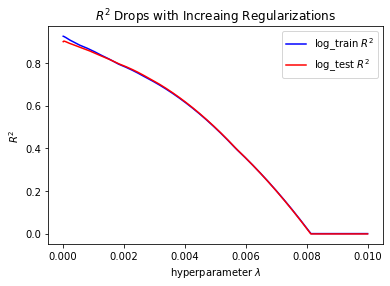

In [148]:
plt.plot(log_alphas, log_trainr2, c='b', label=r'log_train $R^2$')
plt.plot(log_alphas, log_testr2, c='r', label=r'log_test $R^2$')
plt.legend(loc=1)
plt.title(r'$R^2$ Drops with Increaing Regularizations')
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

In [149]:
#alpha which maximized the log_testr2
log_maxind=log_testr2.index(max(log_testr2))
log_bestalpha=log_alphas[log_maxind]
log_bestalpha

3.003003003003003e-05

Text(0, 0.5, '$R^2$')

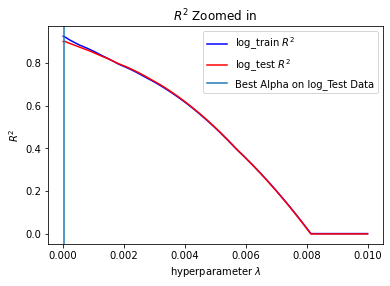

In [150]:
plt.plot(log_alphas, log_trainr2, c='b', label=r'log_train $R^2$')
plt.plot(log_alphas, log_testr2, c='r', label=r'log_test $R^2$')
plt.axvline(x=log_bestalpha,label=r'Best Alpha on log_Test Data')
plt.legend(loc=1)
plt.title(r'$R^2$ Zoomed in')
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

In [156]:
sum(log_coefs_lasso.iloc[log_maxind]!=0)

79

In [151]:
#visualize number of coefs used per log_alpha

log_num_nonzero_coef=[]
for i in range(len(log_alphas)):
    log_num_nonzero_coef.append(sum(log_coefs_lasso.iloc[i]!=0))

No handles with labels found to put in legend.


Text(0, 0.5, '# non zero coefs')

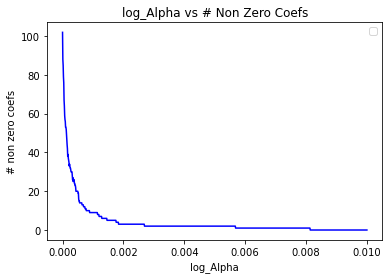

In [152]:
plt.plot(log_alphas, log_num_nonzero_coef, c='b')
plt.legend(loc=1)
plt.title(r'log_Alpha vs # Non Zero Coefs')
plt.xlabel(r'log_Alpha')
plt.ylabel(r'# non zero coefs')

Text(0.5, 0, '# non zero coefs')

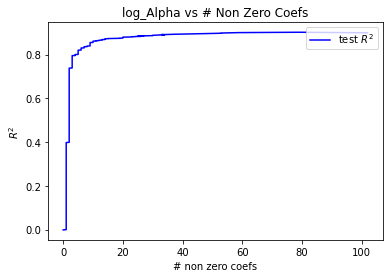

In [153]:
plt.plot(log_num_nonzero_coef,log_testr2, c='b', label=r'test $R^2$')
plt.legend(loc=1)
plt.title(r'log_Alpha vs # Non Zero Coefs')
plt.ylabel(r'$R^2$')
plt.xlabel(r'# non zero coefs')

In [155]:
#Examining the best model

log_lasso.set_params(alpha=log_bestalpha)
log_lasso.fit(log_data_trainx, log_data_trainy)

print('The log_train R2 is ',log_lasso.score(log_data_trainx, log_data_trainy))
print('The log_test R2 is ',log_lasso.score(log_data_testx, log_data_testy))
#pd.DataFrame(lasso.coef_,  columns = data_trainx.columns)
log_columns = log_data_trainx.columns
log_coeflist=list(zip(log_columns,log_lasso.coef_))
log_coefdf=pd.DataFrame(log_coeflist, columns=['Attr','Coef'])
log_coefdf=log_coefdf[log_coefdf.Coef!=0]
log_coefdf.sort_values(by=['Coef'],key=abs)

The log_train R2 is  0.9230789007376871
The log_test R2 is  0.9017388052687233


,Attr,Coef
74,GarageFinish_None,-1.552393e-18
78,GarageFinish_RFn,5.938017e-04
34,Foundation_PConc,7.504418e-04
87,Neighborhood_NWAmes,-8.305161e-04
51,RemodelYrsAftBuilt,1.139741e-03
...,...,...
53,Functional_Maj,-1.109949e-01
0,GrLivArea,1.125070e-01
9,BldgType_Twnhs,-1.199627e-01
28,Exterior1st_AsbShng,-1.250333e-01
